# Setting the stage

In [ ]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib widget

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import glob   
import scipy.interpolate as si

# Functions

In [3]:
def fitstodat2(
    fitsfile,
    wavcol="WAVELENGTH",
    fluxcol="FLUX",
    prefix="",
    sufix="",
    instrum=True,
    obs_date_end=True,
    xfactor=1,
    yfactor=1,
):
    sp = fits.open(fitsfile, ignore_missing_simple=True)  # .verify('fix+ignore')
    bintable = sp[1]
    x = bintable.columns[wavcol]
    y = bintable.columns[fluxcol]
    date = ""

    if obs_date_end == True:
        date = str(sp[0].header["MJD-OBS"])
    else:
        date = ""

    if instrum == True:
        instrum = str(sp[0].header["INSTRUME"].replace(" ", ""))
    else:
        instrum = ""

    W = bintable.data[x.name].T * xfactor
    if W[0] < 1000:
        W = bintable.data[x.name].T * xfactor * 10
    F = bintable.data[y.name].T * yfactor

    filename = fitsfile.split(".fits")[0]
    concated = np.c_[np.hstack((W[2:-3,])), np.hstack((F[2:-3,]))]
    sorted_array = concated[concated[:, 0].argsort()]
    np.savetxt(
        prefix + filename + sufix + "_" + date + "_" + instrum + ".dat", sorted_array
    )


def fitstodat3(
    fitsfile,
    wavcol_list=["WAVELENGTH", "WAVE"],
    fluxcol_list=["FLUX"],
    prefix="",
    sufix="",
    xfactor=1,
    yfactor=1,
):
    sp = fits.open(fitsfile)
    bintable = sp[1]
    #     print(type(str(bintable.columns.names[0])))
    for w, wavcol in enumerate(wavcol_list):
        print(wavcol)
        if wavcol_list[w] in bintable.columns.names:
            print(wavcol_list[w])
            x = bintable.columns[wavcol_list[w]]
    #             break

    for f, fluxcol in enumerate(fluxcol_list):
        print(fluxcol_list[f])
        if fluxcol_list[f] in bintable.columns.names:
            y = bintable.columns[fluxcol_list[f]]
    # #             break

    #     print(x)
    #     y=bintable.columns[fluxcol]

    W = bintable.data[x.name].T * xfactor
    F = bintable.data[y.name].T * yfactor

    filename = fitsfile.split(".")[0]
    concated = np.c_[np.hstack((W[2:-3,])), np.hstack((F[2:-3,]))]
    sorted_array = concated[concated[:, 0].argsort()]
    np.savetxt(prefix + filename + sufix + ".dat", sorted_array)


def fitstodat4(
    fitsfile,
    wavcol_list=["WAVELENGTH"],
    fluxcol_list=["FLUX"],
    prefix="",
    sufix="",
    instrum=True,
    obs_date_end=True,
    waverange=True,
    xfactor=1,
    yfactor=1,
):
    sp = fits.open(fitsfile, ignore_missing_simple=True)  # .verify('fix+ignore')
    bintable = sp[1]
    date = ""

    for w, wavcol in enumerate(wavcol_list):
        if wavcol_list[w] in bintable.columns.names:
            x = bintable.columns[wavcol_list[w]]
    #             break

    for f, fluxcol in enumerate(fluxcol_list):
        if fluxcol_list[f] in bintable.columns.names:
            y = bintable.columns[fluxcol_list[f]]

    W = bintable.data[x.name].T * xfactor
    if W[0] < 1000:
        W = bintable.data[x.name].T * xfactor * 10
    F = bintable.data[y.name].T * yfactor

    if obs_date_end == True:
        date = str(sp[0].header["MJD-OBS"])
    else:
        date = ""

    if instrum == True:
        instrum = str(sp[0].header["INSTRUME"].replace(" ", ""))
    else:
        instrum = ""

    if waverange == True:
        waverange = str(int(min(W))) + "-" + str(int(max(W)))
    else:
        waverange = ""

    filename = fitsfile.split(".fits")[0]
    concated = np.c_[np.hstack((W[2:-3,])), np.hstack((F[2:-3,]))]
    sorted_array = concated[concated[:, 0].argsort()]
    np.savetxt(
        prefix
        + filename
        + sufix
        + "_"
        + date
        + "_"
        + instrum
        + "_"
        + waverange
        + ".dat",
        sorted_array,
    )

In [4]:
def readobs(
    file, wavcol="wavelength", fluxcol="flux", sep="\s+", comment="#", header=None
):
    # read the ascii file into a dataframe
    df = pd.read_csv(
        file, sep=sep, comment=comment, header=header, dtype=float, encoding="utf-8"
    )
    # Get the column names
    columns = list(df.columns)
    # Rename the first two columns
    columns[0] = wavcol
    columns[1] = fluxcol
    # Update the dataframe with the new column names
    df.columns = columns
    return df

# Data extraction from FITS

* Obtain the wavelength and flux from the FITS files
* Save them as ASCII files
* Read the ASCII files as Pandas.DataFrame

In [6]:
# star_dir = "../Hydro-Z1-Sco/OBSERVATIONS/OP/archive//"
# star_dir = "../WR-SMC/SMC-AB-12/archive/"
# star_dir = "../WR-SMC/SMC-AB-04//archive/"
# star_dir = "../WR-SMC/WR-102//archive/"
# star_dir = "../LBVs/AG-Car//archive/"
# star_dir = "../BHGs/HD168625/archive/"
# star_dir = "../BHGs/HD80077//archive/"
# star_dir = "../ESO-P116/UVES-ESOA/archive/"
# star_dir = "../ESO-P116/Spitzer-Ardila10/"
star_dir = "ESPRESSO_Antares_B/"

# OP_fitslist = [f for f in glob.glob("../BHGs/SK6702/UV/HLSP/hlsp_ullyses_hst-fuse_fuse-stis_sk-67d2_uv/hlsp_ullyses_hst-fuse_fuse-stis_sk-67d2_uv_dr7_preview-spec.fits")]
# OP_fitslist = [f for f in glob.glob("../BHGs/BP-CRU/OBSERVATIONS/OP/ESO-archive/*fits")]
# OP_fitslist = [f for f in glob.glob("../BHGs/BP-CRU/OBSERVATIONS/IR/*fits")]
# OP_fitslist = [f for f in glob.glob("../Naked-giants/OBSERVATIONS/OP/*fits")]
# OP_fitslist = [f for f in glob.glob("../BHGs/HR-CAR/*fits")]
# OP_fitslist = [f for f in glob.glob("../Boring-B/Ome Sco/*fits")]
OP_fitslist = [f for f in glob.glob(star_dir + "*fits")]
# OP_fitslist = [f for f in glob.glob("../BHGs/HD80077/archive/*fits")]
# OP_fitslist = [f for f in glob.glob("../Hydro-Z1-Sco/OBSERVATIONS/OP/Final/*fits")]

for i in range(0, len(OP_fitslist)):
    print(OP_fitslist[i])
    fitstodat4(
        OP_fitslist[i],
        wavcol_list=["WAVE", "WAVELENGTH"],
        fluxcol_list=["FLUX", "FLUX_REDUCED"],
        obs_date_end=False,
        instrum=False,
    )

print("---")
# OP_datlist = [f for f in glob.glob(star_dir+"*dat")]
# l=len(OP_datlist)
# OP_dict = {}
# for file in OP_datlist:
#     name = file.split("/")[-1]
#     OP_dict[name] = pd.read_csv(file,names=["wave","flux"],sep=" ")


# for spec in OP_dict.keys():
#     OP_dict[spec]['wave'] = OP_dict[spec]['wave'].apply(lambda x: x * 10 if x < 2500 else x) # nm to Ang
#     plt.plot(OP_dict[spec].wave,OP_dict[spec].flux/np.median(OP_dict[spec].flux),label=spec)

---


In [11]:
OP_datlist = [f for f in glob.glob(star_dir + "*txt")]
l = len(OP_datlist)
OP_dict = {}
for file in OP_datlist:
    name = file.split("/")[-1]
    OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")
    print(name)


for spec in OP_dict.keys():
    # OP_dict[spec]["wave"] = OP_dict[spec]["wave"].apply(
    #     lambda x: x * 10 if x < 2500 else x
    # )  # nm to Ang
    plt.plot(
        OP_dict[spec].wave,
        OP_dict[spec].flux / np.median(OP_dict[spec].flux),
        label=spec,
    )

/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:50:27.128_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:37:25.065_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:28:45.319_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T09:10:27.062_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:26:55.590_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:28:45.474_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:46:20.325_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:29:45.845_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:24:37.224_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:37:24.766_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:36:25.577_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:33:17.623_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:29:45.442_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:51:35.183_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:34:23.499_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T09:11:31.544_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:51:35.036_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:50:26.952_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:36:25.279_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T09:12:22.691_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:30:47.560_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:48:43.105_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T09:08:08.111_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T09:12:22.568_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:47:48.581_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T09:10:27.161_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:32:15.419_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T09:07:17.509_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T09:00:30.415_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T09:11:31.375_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:38:23.094_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:52:43.528_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:38:22.679_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:52:43.356_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T08:30:47.696_t1.txt


/tmp/ipykernel_1982925/2462158315.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  OP_dict[name] = pd.read_csv(file, names=["wave", "flux", "errflux"], sep=" ,")


QC0.ESPRE.2025-02-14T09:05:56.964_t1.txt


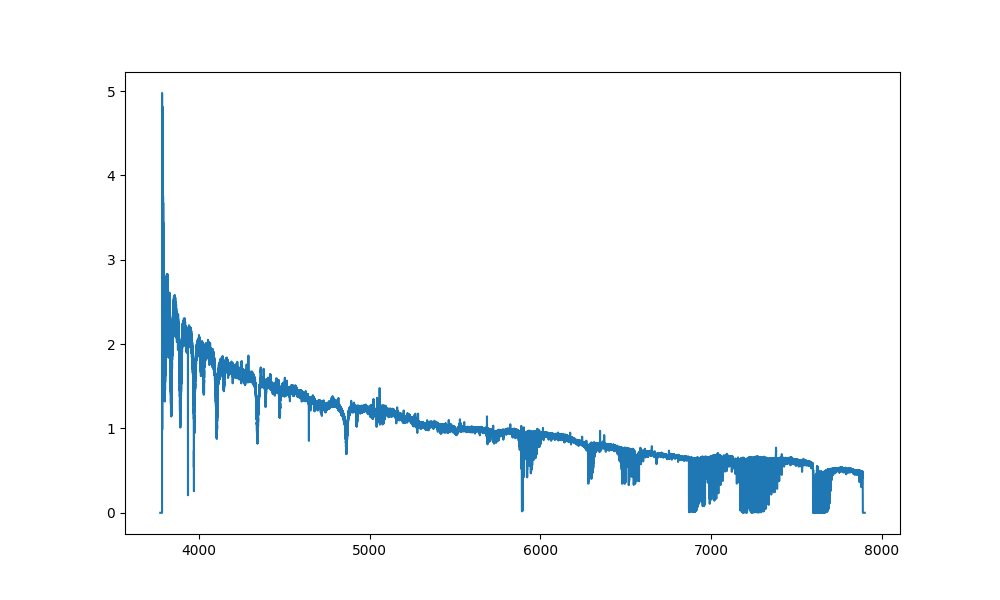

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    OP_dict["QC0.ESPRE.2025-02-14T08:50:27.128_t1.txt"].wave,
    OP_dict["QC0.ESPRE.2025-02-14T08:50:27.128_t1.txt"].flux
    / np.median(OP_dict["QC0.ESPRE.2025-02-14T08:50:27.128_t1.txt"].flux),
    label="QC0",
)

# (Semi-)automatic Normalization

* Find the error at each chunk of the spectrum
* Divide the spectrum in "tiny" pieces (~5 to ~20 Ang)
* If the distribution of points in one of these "tiny pieces" is larger than the error estimated from the chunk it belongs → Skip
* If not: fix a point there.
* Divide the calibrated spcectrum by the curve set by the points

## Single spectrum

In [ ]:
# ========Zeta1 Sco
# # spectrum = OP_dict["ADP.2020-06-12T14:50:18.561_56726.241445611_UVES.dat"]
# spectrum = OP_dict["ADP.2021-04-19T11:23:47.577_58545.31262764_ESPRESSO_3772-7899.dat"]
# # spectrum = OP_dict["ADP.2014-09-16T11:06:37.480_53827.37327948_HARPS.dat"]
spectrum = OP_dict["ADP.2017-09-22T08:44:36.022_57958.09196137_XSHOOTER_9940-24789.dat"]
spectrum = OP_dict["ADP.2017-09-22T08:44:36.053_57958.091862258_XSHOOTER_2989-5559.dat"]
spectrum = OP_dict[
    "ADP.2017-09-22T08:44:36.061_57958.091922797_XSHOOTER_5336-10200.dat"
]
spectrum = OP_dict[
    "ADP.2017-09-22T08:44:36.061_57958.091922797_XSHOOTER_5336-10200.dat"
]
# spectrum = OP_dict["ADP.2020-06-26T07:20:01.040_54897.36238042_UVES.dat"]
# # spectrum = OP_dict["ADP.2020-08-04T19:29:34.489_52806.08299859_UVES.dat"]
# spectrum = OP_dict["ADP.2017-10-16T11:14:19.580_57999.124562478_XSHOOTER_5336-10200.dat"]
# spectrum = OP_dict["ADP.2017-10-16T11:14:19.576_57999.12637069_XSHOOTER_9940-24789.dat"]
# spectrum_name = "ADP.2017-10-16T11:14:19.576_57999.12637069_XSHOOTER_9940-24789.dat"
# ========= SMC AB 12
# spectrum = OP_dict["ADP.2021-12-08T10:55:07.434_59527.176912331_UVES.dat"]
# spectrum = OP_dict["ADP.2022-08-22T08:38:48.316_59791.22322978_UVES.dat"]
# spectrum = OP_dict["ADP.2022-01-24T16:19:40.503_59561.03870142_UVES.dat"]

XSH_list = []
for s in OP_dict:
    if "UVES" in s:
        print(s)

spectrum_name = "ADP.2017-09-22T08:44:36.022_57958.09196137_XSHOOTER_9940-24789.dat"
spectrum_name = "ADP.2017-09-22T08:44:36.053_57958.091862258_XSHOOTER_2989-5559.dat"
spectrum_name = "ADP.2017-09-22T08:44:36.061_57958.091922797_XSHOOTER_5336-10200.dat"
spectrum_name = "ADP.2017-09-22T08:51:17.001_57960.972066497_XSHOOTER_2989-5559.dat"
spectrum_name = "ADP.2017-09-22T08:51:17.062_57960.972127266_XSHOOTER_5336-10200.dat"
spectrum_name = "ADP.2017-09-22T08:44:36.053_57958.091862258_XSHOOTER_2989-5559.dat"
spectrum_name = "ADP.2017-09-22T08:46:32.058_57958.972913507_XSHOOTER_2989-5559.dat"
spectrum_name = "ADP.2017-10-16T11:14:19.495_57999.12794643_XSHOOTER_9940-24789.dat"
spectrum_name = "ADP.2017-09-22T08:51:16.963_57960.97573829_XSHOOTER_9940-24789.dat"
spectrum_name = "ADP.2017-09-22T08:51:16.920_57960.975646416_XSHOOTER_2989-5559.dat"
spectrum_name = "ADP.2017-10-16T11:14:19.511_57999.124502285_XSHOOTER_2989-5559.dat"
spectrum_name = "ADP.2017-10-16T11:14:19.576_57999.12637069_XSHOOTER_9940-24789.dat"
spectrum_name = "ADP.2017-10-16T11:14:19.532_57999.126338796_XSHOOTER_5336-10200.dat"
spectrum_name = "ADP.2017-09-22T08:51:17.049_57960.97216241_XSHOOTER_9940-24789.dat"
spectrum_name = "ADP.2017-09-22T08:44:36.061_57958.091922797_XSHOOTER_5336-10200.dat"
spectrum_name = "ADP.2017-10-16T11:14:19.580_57999.124562478_XSHOOTER_5336-10200.dat"
spectrum_name = "ADP.2017-09-22T08:44:36.022_57958.09196137_XSHOOTER_9940-24789.dat"
spectrum_name = "ADP.2017-09-22T08:46:32.223_57958.97300504_XSHOOTER_9940-24789.dat"
spectrum_name = "ADP.2017-10-16T11:14:19.462_57999.124596_XSHOOTER_9940-24789.dat"
spectrum_name = "ADP.2017-09-22T08:46:32.268_57958.972973697_XSHOOTER_5336-10200.dat"
spectrum_name = "ADP.2017-10-16T11:14:19.542_57999.126278027_XSHOOTER_2989-5559.dat"
spectrum_name = "ADP.2017-10-16T11:14:19.645_57999.12784993_XSHOOTER_2989-5559.dat"
spectrum_name = "ADP.2017-09-22T08:51:16.936_57960.975706494_XSHOOTER_5336-10200.dat"

spectrum_name = "ADP.2020-06-26T07:20:00.952_54897.35319058_UVES_6650-10426.dat"
spectrum_name = (
    "ADP.2020-06-26T07:20:00.890_54897.34109782_UVES_4583-6686.dat"  # cagado
)
spectrum_name = "ADP.2020-06-26T07:20:01.080_54897.35738974_UVES_3732-4999.dat"
spectrum_name = "ADP.2020-06-26T07:20:01.211_54897.35326708_UVES_3732-4999.dat"
spectrum_name = "ADP.2020-06-26T07:20:01.430_54897.35734384_UVES_6650-10426.dat"
spectrum_name = "ADP.2020-06-26T07:20:01.434_54897.33508336_UVES_3044-3916.dat"
spectrum_name = "ADP.2020-06-26T07:20:01.235_54897.35543022_UVES_3732-4999.dat"
spectrum_name = "ADP.2020-08-04T19:29:34.489_52806.08299859_UVES_3731-4999.dat"
spectrum_name = "ADP.2020-06-26T07:20:00.966_54897.34122133_UVES_3044-3916.dat"
spectrum_name = "ADP.2020-06-26T07:20:00.824_54897.3622554_UVES_6650-10426.dat"
spectrum_name = "ADP.2020-09-14T20:36:53.520_51726.05632964_UVES_3043-3916.dat"
spectrum_name = "ADP.2020-06-26T07:20:01.189_54897.33503732_UVES_4583-6686.dat"
spectrum_name = "ADP.2020-06-26T07:20:01.040_54897.36238042_UVES_3732-4999.dat"
spectrum_name = "ADP.2020-06-26T07:20:01.207_54897.35536762_UVES_6650-10426.dat"

# ========= SMC AB 04
# spectrum = OP_dict["ADP.2024-10-24T11:58:09.779_59156.15780123_XSHOOTER_3000-10200.dat"]

# ========= WR 102
# spectrum = OP_dict['ADP.2014-05-17T20:27:25.310_56490.068814423_XSHOOTER_2989-5559.dat']

# ========= AG Car
# spectrum = OP_dict['ADP.2020-06-08T14:42:27.472_58526.286245141_UVES_4583-6686.dat']
# spectrum = OP_dict['ADP.2020-08-04T13:57:50.820_52651.37427777_UVES_3731-4999.dat']

# ========= HD162586
# spectrum_name = "ADP.2014-06-03T08:10:36.030_56804.275796782_XSHOOTER_2989-5559.dat"
# spectrum_name = "ADP.2020-08-14T11:18:19.999_52100.17179235_UVES_4726-6835.dat"
# spectrum_name = "ADP.2020-08-14T11:18:19.931_52100.18104779_UVES_3731-4999.dat"


spectrum = OP_dict[spectrum_name]
spectrum.fillna(0)
spectrum.flux[spectrum.flux < 0] = 0


print(spectrum)

wavstep = 2  # Ang
wave_start = np.array(spectrum.wave)[0]
wave_end = np.array(spectrum.wave)[-1]
# N_divs = int(len(spectrum.wave)/wavstep)
N_divs = int((wave_end - wave_start) / wavstep)
offset_sta = 0  # Ang
offset_end = 0  # Ang

err_N_divs = 15
errstep = (wave_end - offset_end - wave_start + offset_sta) / err_N_divs

start_masks = [[wave_start, wave_start + 80]]
endwl_masks = [[wave_end - 1, wave_end]]
ismed_masks = [
    [4420, 4460],
    [4840, 4950],
]  # masks for interstellar medium bands chasing cornfields
tellu_masks = [
    [6865, 6945],
    [7580, 7775],
    [8125, 8325],
    [8920, 9860],
    [11100, 11670],
    [13000, 14900],
    [17350, 19760],
    [19900, 20300],
    [20418, 20770],
    [20350, 20950],
]  # masks for telluric FUCKING lines
elesc_masks = []  # masks for electron scattering wings I'M SCAT MAN!
instr_masks = []  # masks for instrumental error (flaring on the edges)

all_masks = [
    start_masks,
    ismed_masks,
    tellu_masks,
    elesc_masks,
    instr_masks,
    endwl_masks,
]

sparse_wave = []
sparse_flux_medi = []
sparse_flux_mean = []
sparse_flux_hmea = []
sparse_flux_stdd = []
sparse_snr = []

sparse_wave_phased = []
sparse_flux_medi_phased = []
sparse_flux_mean_phased = []
sparse_flux_hmea_phased = []
sparse_flux_stdd_phased = []
sparse_snr_phased = []


###############################################################################################
plt.figure(666)
plt.subplot(211)

# Remove the parts of teh spectrum that overlap with the masked regions (tellurics, ISM features, etc)
spectrum_tmp = spectrum.copy()
for masktype in all_masks:
    for mask in masktype:
        death_mask = (spectrum_tmp.wave >= mask[0]) & (spectrum_tmp.wave <= mask[1])
        spectrum_tmp.flux[death_mask] = np.nan

# Compute the errors at different segments of the spectrum
wav0 = wave_start
err_list = []
err_lim_list = []
err_lim0_list = []
for w in range(0, err_N_divs):
    plt.axvline(
        [wav0 + offset_sta], c="fuchsia", lw=1.0, alpha=0.5
    )  # plot the borders of the chunks where the local error will be defined
    interval_big = (spectrum_tmp.wave > wav0 + offset_sta) & (
        spectrum_tmp.wave <= wav0 + errstep + offset_sta
    )  # create the cut for the chunk
    N_divs_int = 70
    stepsma = (
        max(spectrum_tmp.wave[interval_big]) - min(spectrum_tmp.wave[interval_big])
    ) / N_divs_int
    std_list = []
    wav00 = wav0
    for i in range(0, N_divs_int):
        plt.axvline([wav00], c="cyan", lw=0.5, alpha=0.5)
        interval_sma = (spectrum_tmp.wave > wav00) & (
            spectrum_tmp.wave <= wav00 + stepsma
        )

        std_list.append(np.nanstd(spectrum_tmp.flux[interval_sma]))
        wav00 += stepsma

    err_list.append(np.nanmedian(np.array(std_list)))
    err_lim_list.append(wav0)
    err_lim0_list.append(wav0 + errstep)
    wav0 += errstep

err_list = np.array(err_list)
err_list[np.isnan(err_list)] = np.nanmedian(err_list)

err_lim_list = np.array(err_lim_list)
err_lim0_list = np.array(err_lim0_list)
err_lim_mid_list = (err_lim_list + err_lim0_list) / 2

for masktype in all_masks:
    for mask in masktype:
        plt.axvspan(mask[0], mask[1], alpha=0.5, color="goldenrod")

plt.plot(spectrum.wave, spectrum.flux, zorder=-3, c="k")
plt.xlim(min(spectrum.wave), max(spectrum.wave))
plt.ylabel("Cali. flux")


plt.subplot(212, sharex=plt.gca())
plt.plot(err_lim_mid_list, err_list, marker="o", c="fuchsia")
plt.ylabel("Error at each chunk")
plt.xlabel("$\lambda$ [$\AA$]")

plt.show()

###############################################################################
###############################################################################
###############################################################################
plt.figure(777)
plt.subplot(311)
wav0 = wave_start
for w in range(0, N_divs):
    plt.axvline([wav0 + offset_sta], c="pink", lw=0.5, alpha=0.5)
    interval = (spectrum_tmp.wave > wav0 + offset_sta) & (
        spectrum_tmp.wave <= wav0 + wavstep + offset_sta
    )
    # select the error of the corresponding range
    e = 0
    for ww, wavlim in enumerate(err_lim_list[1:]):
        if wav0 > err_lim_list[ww - 1] and wav0 < err_lim_list[ww]:
            break
        else:
            e += 1

    snr = err_list[e]

    if len(spectrum_tmp.wave[interval]) > 10:
        if (
            abs(sp.stats.skew(spectrum_tmp.flux[interval], nan_policy="omit")) < 0.5
            and sp.stats.kurtosis(spectrum_tmp.flux[interval], nan_policy="omit") > -2
            and np.nanstd(spectrum_tmp.flux[interval]) < 1.20 * snr
        ):
            # if abs(sp.stats.skew(spectrum_tmp.flux[interval],nan_policy="omit")) < 0.5 and np.nanstd(spectrum_tmp.flux[interval]) < 1.20*snr :
            # if sp.stats.skewtest(spectrum_tmp.flux[interval],nan_policy="omit").pvalue > 0.005 and np.nanstd(spectrum_tmp.flux[interval]) < 1.20*snr :
            sparse_wave.append((wav0 + offset_sta + wav0 + wavstep + offset_sta) / 2)
            sparse_flux_medi.append(np.nanmedian(spectrum_tmp.flux[interval]))
            sparse_flux_mean.append(np.nanmean(spectrum_tmp.flux[interval]))
            sparse_flux_hmea.append(sp.stats.hmean(spectrum_tmp.flux[interval]))
            sparse_flux_stdd.append(np.nanstd(spectrum_tmp.flux[interval]))
            sparse_snr.append(snr)

    wav0 += wavstep


wav0 = wave_start
for w in range(0, N_divs):
    plt.axvline([wav0 + offset_sta + wavstep / 2], c="cyan", lw=0.5, alpha=0.5)
    interval = (spectrum_tmp.wave > wav0 + offset_sta + wavstep / 2) & (
        spectrum_tmp.wave <= wav0 + wavstep + offset_sta + wavstep / 2
    )

    e = 0
    for ww, wavlim in enumerate(err_lim_list[1:]):
        if wav0 > err_lim_list[ww - 1] and wav0 < err_lim_list[ww]:
            break
        else:
            e += 1

    snr = err_list[e]

    if len(spectrum_tmp.wave[interval]) > 10:
        if (
            abs(sp.stats.skew(spectrum_tmp.flux[interval], nan_policy="omit")) < 0.5
            and sp.stats.kurtosis(spectrum_tmp.flux[interval], nan_policy="omit") > -2
            and np.nanstd(spectrum_tmp.flux[interval]) < 1.20 * snr
        ):
            # if abs(sp.stats.skew(spectrum_tmp.flux[interval],nan_policy="omit")) < 0.5 and np.nanstd(spectrum_tmp.flux[interval]) < 1.20*snr :
            # if sp.stats.skewtest(spectrum_tmp.flux[interval],nan_policy="omit").pvalue > 0.005 and np.nanstd(spectrum_tmp.flux[interval]) < 1.20*snr :
            sparse_wave_phased.append(
                (
                    wav0
                    + offset_sta
                    + wavstep / 2
                    + wav0
                    + wavstep
                    + offset_sta
                    + wavstep / 2
                )
                / 2
            )
            sparse_flux_medi_phased.append(np.nanmedian(spectrum_tmp.flux[interval]))
            sparse_flux_mean_phased.append(np.nanmean(spectrum_tmp.flux[interval]))
            sparse_flux_hmea_phased.append(sp.stats.hmean(spectrum_tmp.flux[interval]))
            sparse_flux_stdd_phased.append(np.nanstd(spectrum_tmp.flux[interval]))
            sparse_snr_phased.append(snr)

    wav0 += wavstep

sparse_snr = np.array(sparse_snr)
sparse_snr_phased = np.array(sparse_snr_phased)


plt.plot(spectrum.wave, spectrum.flux, zorder=-3, c="k")
plt.xlim(min(spectrum.wave), max(spectrum.wave))

plt.scatter(sparse_wave, sparse_flux_medi, c="red", marker="x")
plt.errorbar(sparse_wave, sparse_flux_medi, yerr=sparse_flux_stdd, c="red", ls="none")
plt.errorbar(
    sparse_wave,
    sparse_flux_medi,
    yerr=sparse_snr,
    c="pink",
    ls="none",
    lw=8,
    alpha=1,
    zorder=-1,
)
# plt.errorbar(sparse_wave,sparse_flux_medi,yerr=2*sparse_snr,c="pink",ls="none",lw=5,alpha=0.6,zorder=-1)
# plt.scatter(sparse_wave,sparse_flux_mean,c="blue")
# plt.scatter(sparse_wave,sparse_flux_hmea,c="b")

plt.scatter(sparse_wave_phased, sparse_flux_medi_phased, c="blue", marker="x")
plt.errorbar(
    sparse_wave_phased,
    sparse_flux_medi_phased,
    yerr=sparse_flux_stdd_phased,
    c="blue",
    ls="none",
)
plt.errorbar(
    sparse_wave_phased,
    sparse_flux_medi_phased,
    yerr=sparse_snr_phased,
    c="cyan",
    ls="none",
    lw=8,
    alpha=1,
    zorder=-1,
)
# plt.errorbar(sparse_wave_phased,sparse_flux_medi_phased,yerr=2*sparse_snr_phased,c="cyan",ls="none",lw=5,alpha=0.6,zorder=-1)
# plt.scatter(sparse_wave,sparse_flux_mean_phased,c="blue")
# plt.scatter(sparse_wave,sparse_flux_hmea_phased,c="b")


interp_flux = np.interp(
    spectrum.wave, np.array(sparse_wave), np.array(sparse_flux_medi)
)
interp_flux_phased = np.interp(
    spectrum.wave, np.array(sparse_wave_phased), np.array(sparse_flux_medi_phased)
)

for masktype in all_masks:
    for mask in masktype:
        plt.axvspan(mask[0], mask[1], alpha=0.5, color="goldenrod")

plt.plot(spectrum.wave, interp_flux, c="red")
plt.plot(spectrum.wave, interp_flux_phased, c="blue")
plt.ylabel("Cali. flux")

################################################################################################
plt.subplot(312, sharex=plt.gca())
plt.plot(spectrum.wave, spectrum.flux / interp_flux, c="red", alpha=0.6)
plt.plot(spectrum.wave, spectrum.flux / interp_flux_phased, c="blue", alpha=0.6)
norm_flux_mean = (spectrum.flux / interp_flux_phased + spectrum.flux / interp_flux) / 2
plt.plot(spectrum.wave, norm_flux_mean, color="k")
plt.axhline([1], lw=0.5, ls=":", c="grey")
plt.ylabel("Norm. flux")

################################################################################################
plt.subplot(313, sharex=plt.gca())
plt.plot(
    spectrum.wave,
    spectrum.flux / interp_flux_phased - spectrum.flux / interp_flux,
    c="fuchsia",
)
plt.axhline([0], lw=0.5, ls=":", c="grey")
plt.ylabel("Norm. flux")
plt.xlabel("$\lambda$")

################################################################################################


spectrum_norm_mean = pd.DataFrame(
    list(zip(spectrum.wave, norm_flux_mean)), columns=["wave", "flux"]
)
print(spectrum_name)

file = star_dir + "/" + spectrum_name[:-4] + ".norm"
print(file)
spectrum_norm_mean.to_csv(file, sep=" ", index=False)

ADP.2020-06-26T07:20:00.952_54897.35319058_UVES_6650-10426.dat
ADP.2020-06-26T07:20:00.890_54897.34109782_UVES_4583-6686.dat
ADP.2020-06-26T07:20:01.080_54897.35738974_UVES_3732-4999.dat
ADP.2020-06-26T07:20:01.211_54897.35326708_UVES_3732-4999.dat
ADP.2020-06-26T07:20:01.430_54897.35734384_UVES_6650-10426.dat
ADP.2020-06-26T07:20:01.434_54897.33508336_UVES_3044-3916.dat
ADP.2020-06-26T07:20:01.235_54897.35543022_UVES_3732-4999.dat
ADP.2020-08-04T19:29:34.489_52806.08299859_UVES_3731-4999.dat
ADP.2020-06-26T07:20:00.966_54897.34122133_UVES_3044-3916.dat
ADP.2020-06-26T07:20:00.824_54897.3622554_UVES_6650-10426.dat
ADP.2020-09-14T20:36:53.520_51726.05632964_UVES_3043-3916.dat
ADP.2020-06-26T07:20:01.189_54897.33503732_UVES_4583-6686.dat
ADP.2020-06-26T07:20:01.040_54897.36238042_UVES_3732-4999.dat
ADP.2020-06-26T07:20:01.207_54897.35536762_UVES_6650-10426.dat
                wave  flux
0        6650.376251   0.0
1        6650.396374   0.0
2        6650.416497   0.0
3        6650.436619 

/home/Tux/mbperon/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2533846/3036086604.py:153: RuntimeWarning: All-NaN slice encountered
  err_list.append(np.nanmedian(np.array(std_list)))
/home/Tux/mbperon/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1193: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/home/Tux/mbperon/.local/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/Tux/mbperon/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/Tux/mbperon/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ADP.2020-06-26T07:20:01.207_54897.35536762_UVES_6650-10426.dat
../Hydro-Z1-Sco/OBSERVATIONS/OP/archive///ADP.2020-06-26T07:20:01.207_54897.35536762_UVES_6650-10426.norm


## Multiple spectra

/home/Tux/mbperon/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


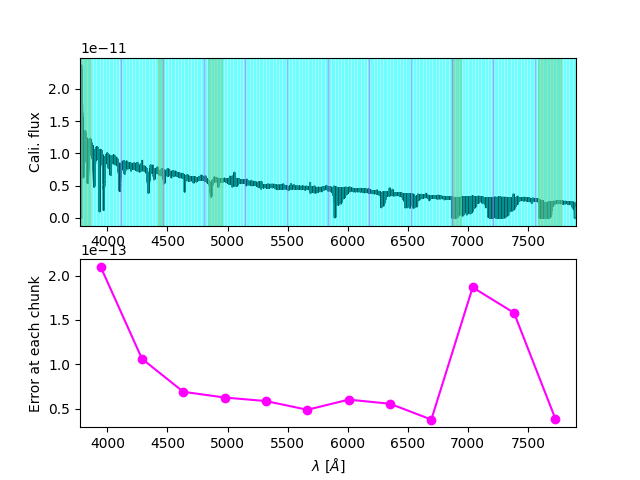

/home/Tux/mbperon/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1193: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/home/Tux/mbperon/.local/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/Tux/mbperon/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/Tux/mbperon/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


QC0.ESPRE.2025-02-14T08:50:27.128_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:50:27.128_t1.norm


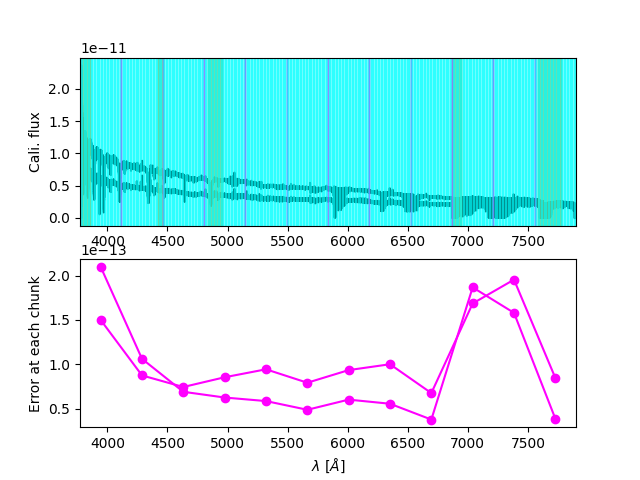

QC0.ESPRE.2025-02-14T08:37:25.065_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:37:25.065_t1.norm


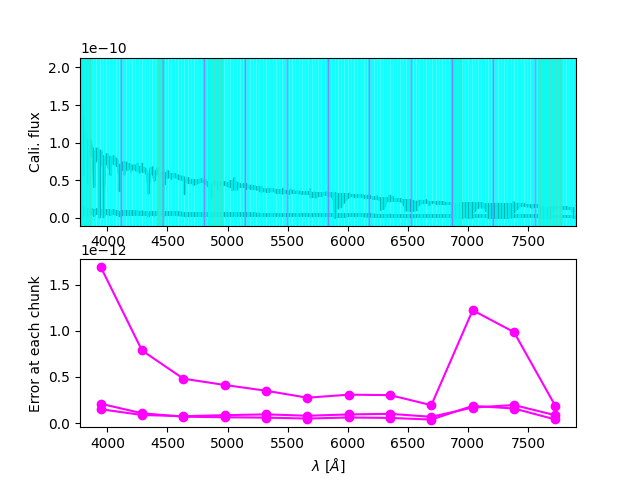

QC0.ESPRE.2025-02-14T08:28:45.319_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:28:45.319_t1.norm


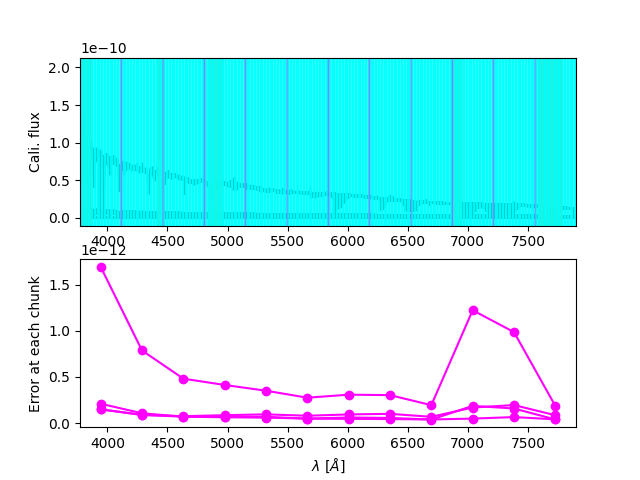

QC0.ESPRE.2025-02-14T09:10:27.062_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T09:10:27.062_t1.norm


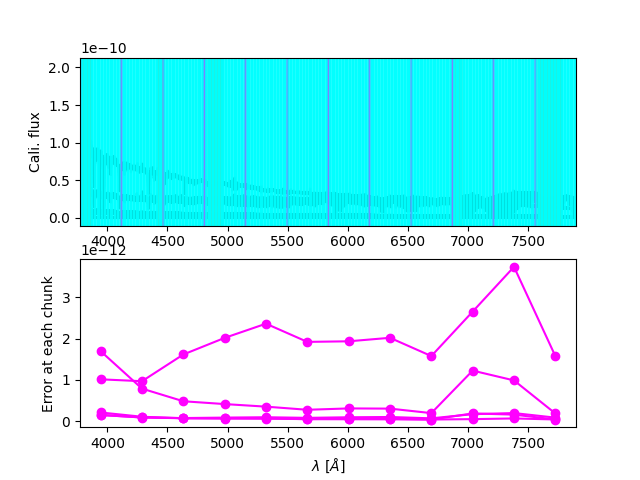

QC0.ESPRE.2025-02-14T08:26:55.590_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:26:55.590_t1.norm


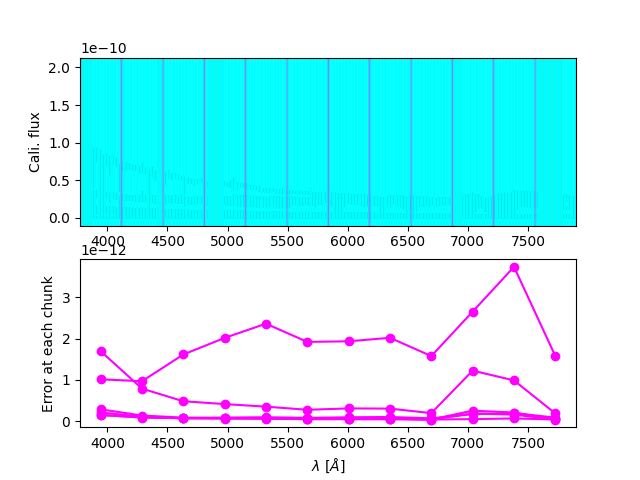

QC0.ESPRE.2025-02-14T08:28:45.474_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:28:45.474_t1.norm


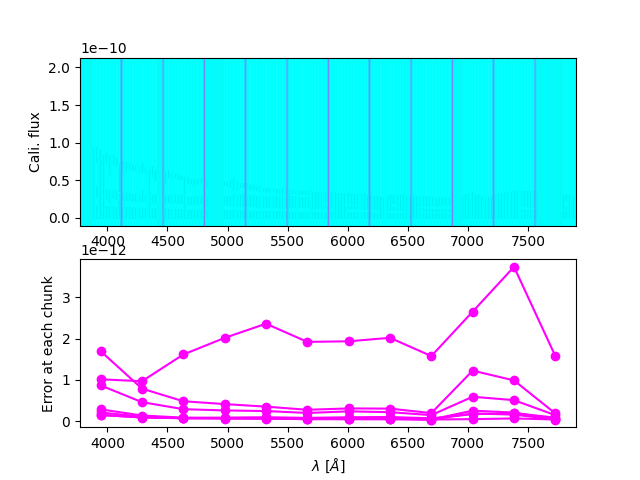

QC0.ESPRE.2025-02-14T08:46:20.325_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:46:20.325_t1.norm


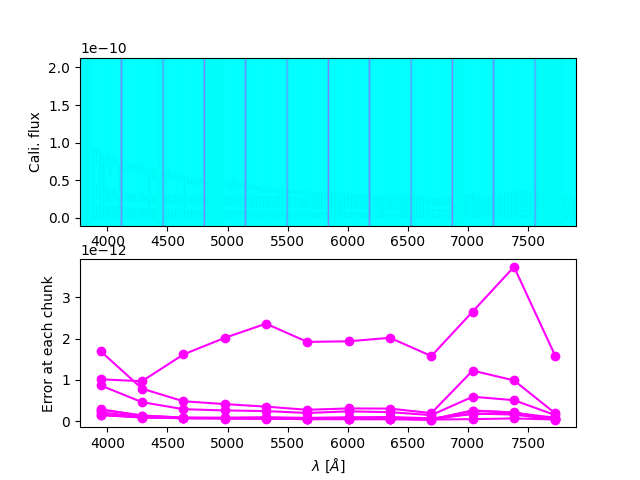

QC0.ESPRE.2025-02-14T08:29:45.845_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:29:45.845_t1.norm


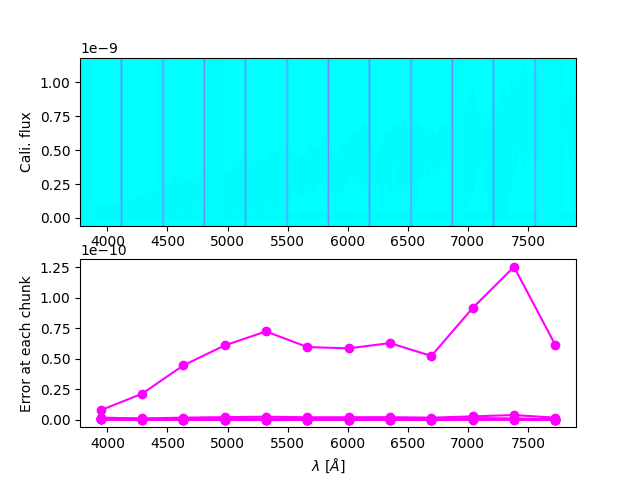

QC0.ESPRE.2025-02-14T08:24:37.224_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:24:37.224_t1.norm


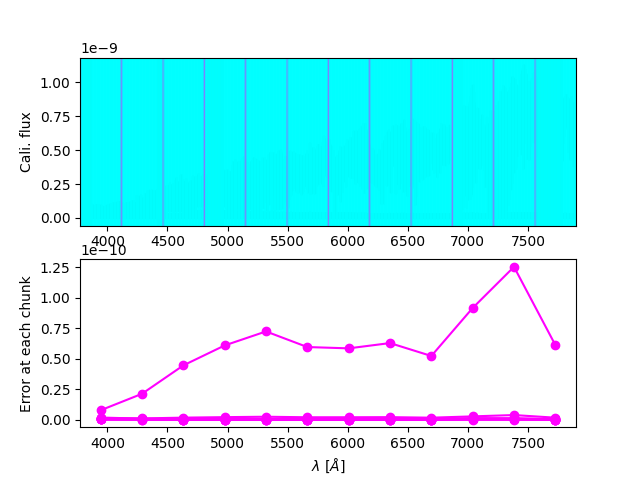

QC0.ESPRE.2025-02-14T08:37:24.766_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:37:24.766_t1.norm


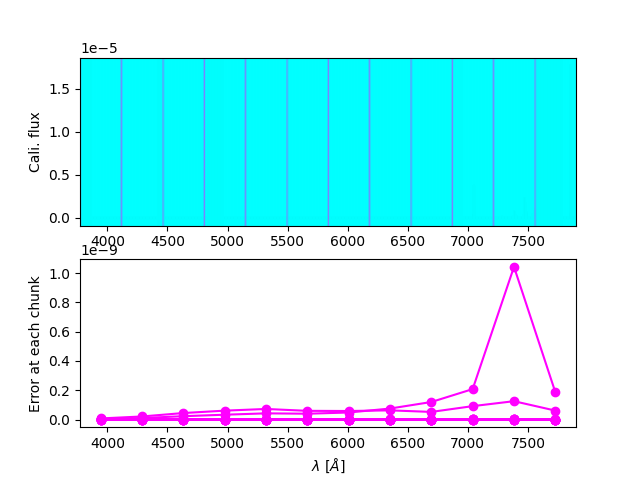

QC0.ESPRE.2025-02-14T08:36:25.577_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:36:25.577_t1.norm


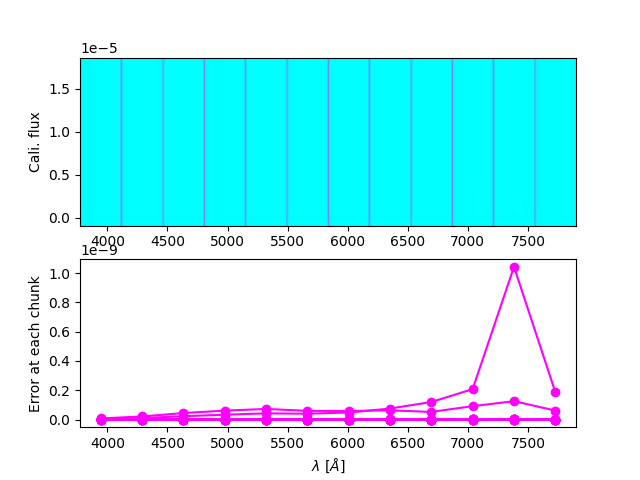

QC0.ESPRE.2025-02-14T08:33:17.623_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:33:17.623_t1.norm


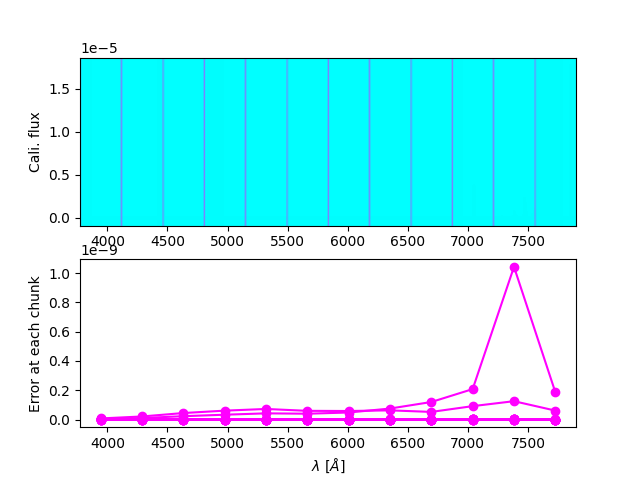

QC0.ESPRE.2025-02-14T08:29:45.442_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:29:45.442_t1.norm


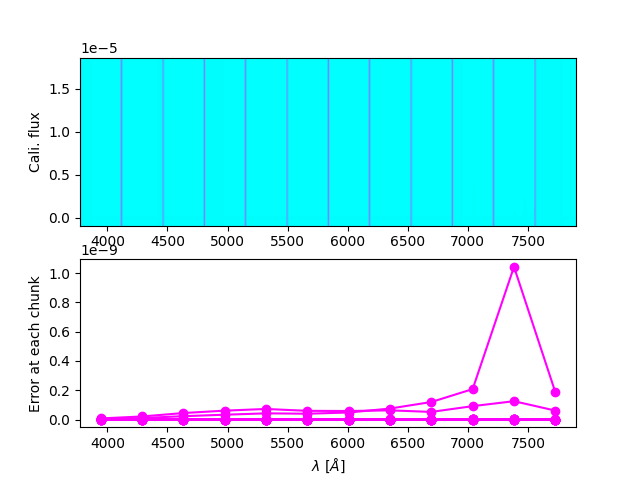

QC0.ESPRE.2025-02-14T08:51:35.183_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:51:35.183_t1.norm


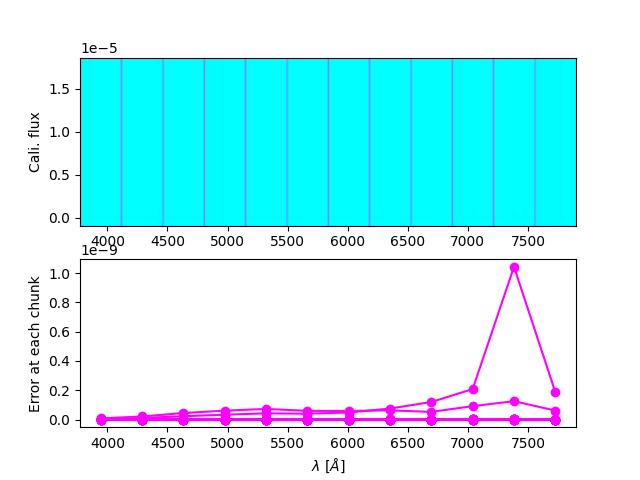

QC0.ESPRE.2025-02-14T08:34:23.499_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:34:23.499_t1.norm


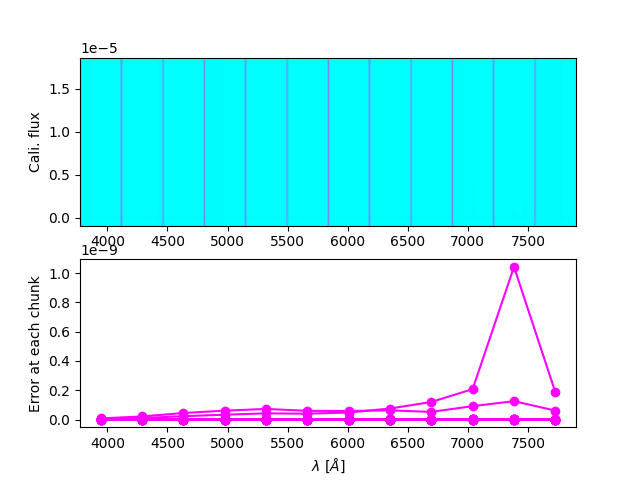

QC0.ESPRE.2025-02-14T09:11:31.544_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T09:11:31.544_t1.norm


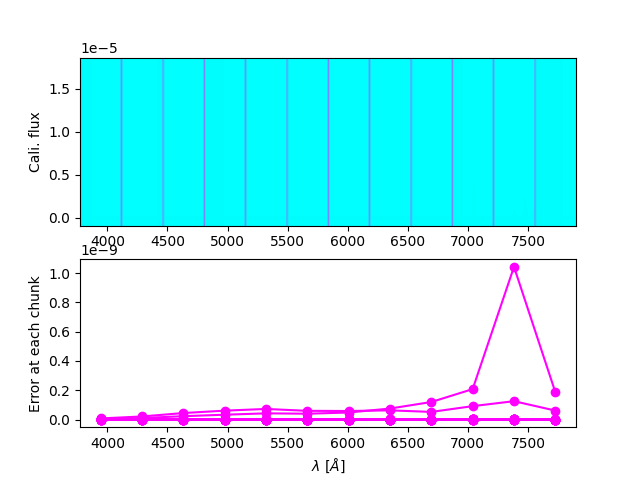

QC0.ESPRE.2025-02-14T08:51:35.036_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:51:35.036_t1.norm


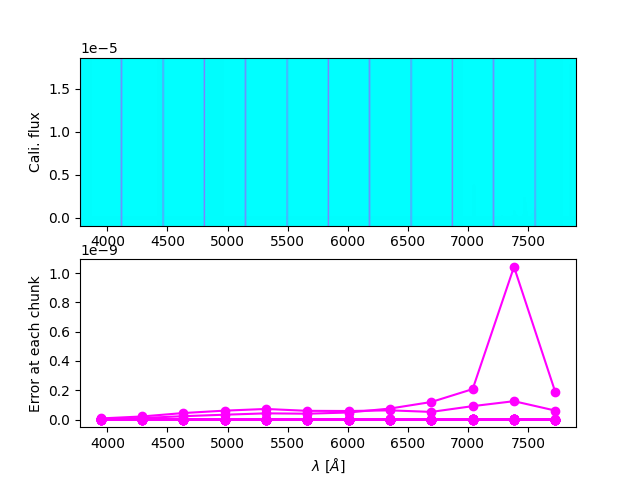

QC0.ESPRE.2025-02-14T08:50:26.952_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:50:26.952_t1.norm


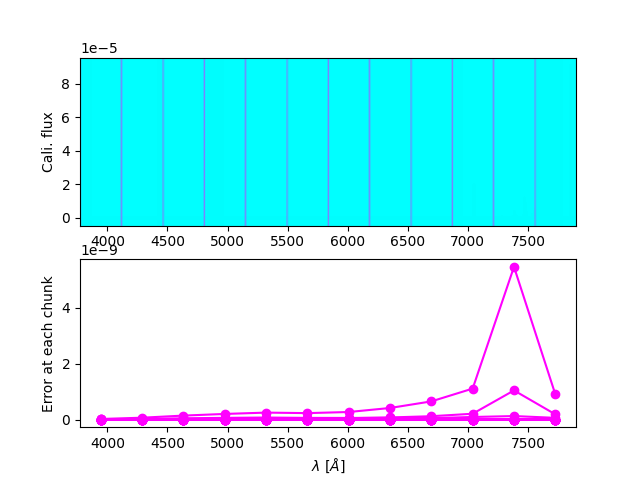

QC0.ESPRE.2025-02-14T08:36:25.279_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:36:25.279_t1.norm


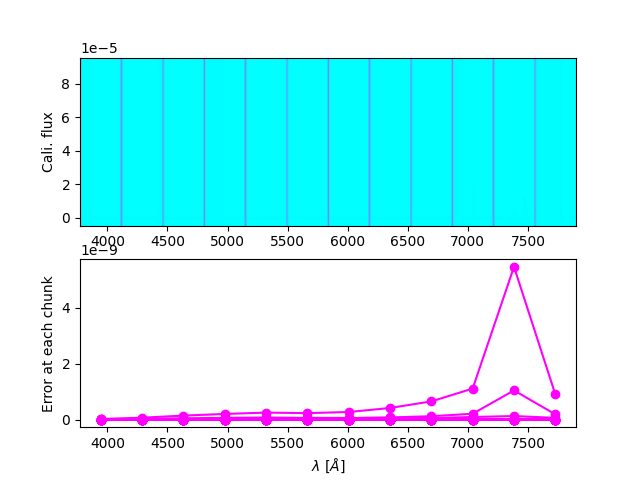

QC0.ESPRE.2025-02-14T09:12:22.691_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T09:12:22.691_t1.norm


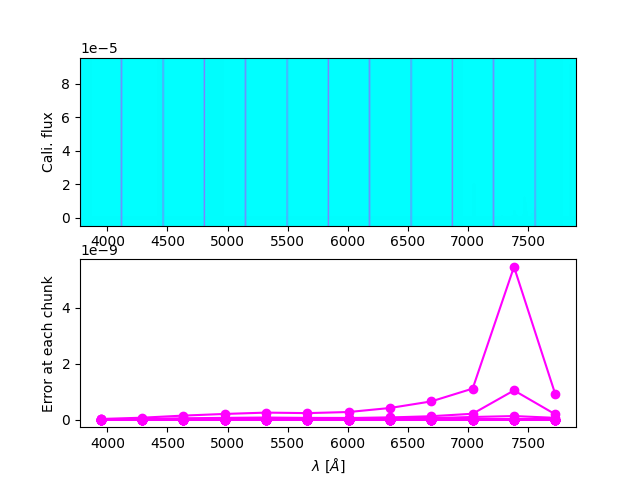

QC0.ESPRE.2025-02-14T08:30:47.560_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:30:47.560_t1.norm


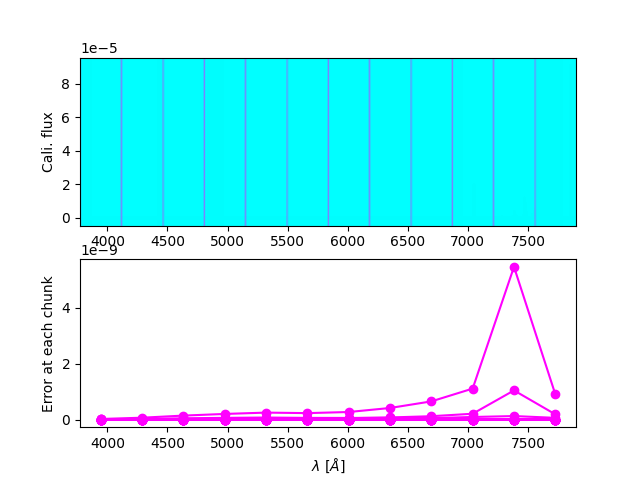

QC0.ESPRE.2025-02-14T08:48:43.105_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T08:48:43.105_t1.norm


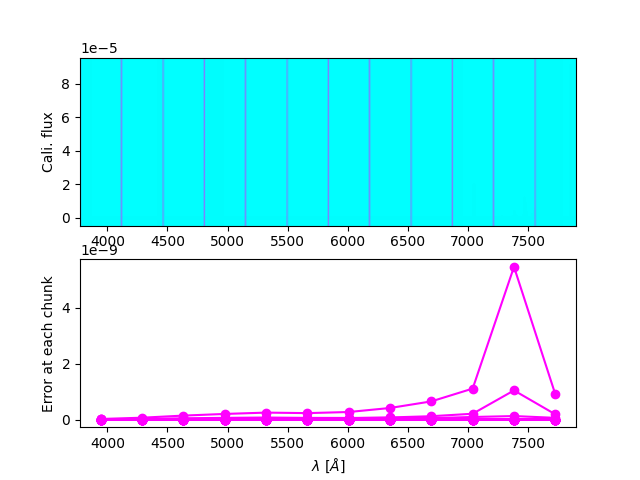

QC0.ESPRE.2025-02-14T09:08:08.111_t1.txt
ESPRESSO_Antares_B//QC0.ESPRE.2025-02-14T09:08:08.111_t1.norm


/tmp/ipykernel_1982925/3906504920.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spectrum.flux[spectrum.flux < 0] = 0


TypeError: unsupported operand type(s) for -: 'str' and 'str'

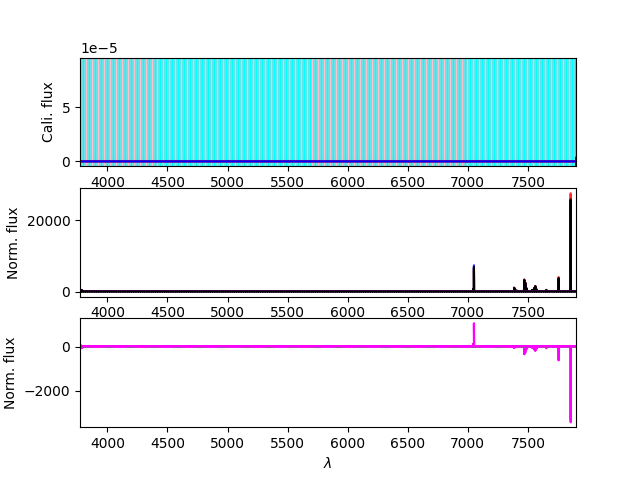

In [18]:
for spectrum_name in OP_dict:

    spectrum = OP_dict[spectrum_name]

    spectrum.fillna(0)
    spectrum.flux[spectrum.flux < 0] = 0

    # ========Zeta1 Sco
    # # spectrum = OP_dict["ADP.2020-06-12T14:50:18.561_56726.241445611_UVES.dat"]
    # spectrum = OP_dict["ADP.2021-04-19T11:23:47.577_58545.31262764_ESPRESSO_3772-7899.dat"]
    # # spectrum = OP_dict["ADP.2014-09-16T11:06:37.480_53827.37327948_HARPS.dat"]
    # spectrum = OP_dict["ADP.2017-09-22T08:44:36.061_57958.091922797_XSHOOTER.dat"]
    # spectrum = OP_dict["ADP.2020-06-26T07:20:01.040_54897.36238042_UVES.dat"]
    # # spectrum = OP_dict["ADP.2020-08-04T19:29:34.489_52806.08299859_UVES.dat"]
    # spectrum = OP_dict["ADP.2017-10-16T11:14:19.580_57999.124562478_XSHOOTER_5336-10200.dat"]
    # spectrum = OP_dict["ADP.2017-10-16T11:14:19.576_57999.12637069_XSHOOTER_9940-24789.dat"]
    # ========= SMC AB 12
    # spectrum = OP_dict["ADP.2021-12-08T10:55:07.434_59527.176912331_UVES.dat"]
    # spectrum = OP_dict["ADP.2022-08-22T08:38:48.316_59791.22322978_UVES.dat"]
    # spectrum = OP_dict["ADP.2022-01-24T16:19:40.503_59561.03870142_UVES.dat"]

    # ========= SMC AB 04
    # spectrum = OP_dict["ADP.2024-10-24T11:58:09.779_59156.15780123_XSHOOTER_3000-10200.dat"]

    # ========= WR 102
    # spectrum = OP_dict['ADP.2014-05-17T20:27:25.310_56490.068814423_XSHOOTER_2989-5559.dat']

    # ========= AG Car
    # spectrum = OP_dict['ADP.2020-06-08T14:42:27.472_58526.286245141_UVES_4583-6686.dat']
    # spectrum = OP_dict['ADP.2020-08-04T13:57:50.820_52651.37427777_UVES_3731-4999.dat']

    # ========= HD162586
    #     spectrum_name = "ADP.2014-06-03T08:10:36.030_56804.275796782_XSHOOTER_2989-5559.dat"
    #     spectrum_name = "ADP.2020-08-14T11:18:19.999_52100.17179235_UVES_4726-6835.dat"
    #     spectrum_name = "ADP.2020-08-14T11:18:19.931_52100.18104779_UVES_3731-4999.dat"

    # #     spectrum = OP_dict[spectrum_name]
    #     spectrum.fillna(0)
    #     spectrum.flux[spectrum.flux < 0] = 0

    wavstep = 10  # Ang
    wave_start = np.array(spectrum.wave)[0]
    wave_end = np.array(spectrum.wave)[-1]
    # N_divs = int(len(spectrum.wave)/wavstep)
    N_divs = int((wave_end - wave_start) / wavstep)
    offset_sta = 0  # Ang
    offset_end = 0  # Ang

    err_N_divs = 12
    errstep = (wave_end - offset_end - wave_start + offset_sta) / err_N_divs

    start_masks = [[wave_start, wave_start + 80]]
    endwl_masks = [[wave_end - 1, wave_end]]
    ismed_masks = [
        [4420, 4460],
        [4840, 4950],
    ]  # masks for interstellar medium bands chasing cornfields
    tellu_masks = [
        [6865, 6945],
        [7580, 7775],
        [8125, 8325],
        [8920, 9860],
        [11100, 11670],
        [13000, 14900],
        [17350, 19760],
        [19900, 20300],
        [20418, 20770],
        [20350, 20950],
    ]  # masks for telluric FUCKING lines
    elesc_masks = []  # masks for electron scattering wings I'M SCAT MAN!
    instr_masks = []  # masks for instrumental error (flaring on the edges)

    all_masks = [
        start_masks,
        ismed_masks,
        tellu_masks,
        elesc_masks,
        instr_masks,
        endwl_masks,
    ]

    sparse_wave = []
    sparse_flux_medi = []
    sparse_flux_mean = []
    sparse_flux_hmea = []
    sparse_flux_stdd = []
    sparse_snr = []

    sparse_wave_phased = []
    sparse_flux_medi_phased = []
    sparse_flux_mean_phased = []
    sparse_flux_hmea_phased = []
    sparse_flux_stdd_phased = []
    sparse_snr_phased = []

    ###############################################################################################
    plt.figure(666)
    plt.subplot(211)

    # Remove the parts of teh spectrum that overlap with the masked regions (tellurics, ISM features, etc)
    spectrum_tmp = spectrum.copy()
    for masktype in all_masks:
        for mask in masktype:
            death_mask = (spectrum_tmp.wave >= mask[0]) & (spectrum_tmp.wave <= mask[1])
            spectrum_tmp.flux[death_mask] = np.nan

    # Compute the errors at different segments of the spectrum
    wav0 = wave_start
    err_list = []
    err_lim_list = []
    err_lim0_list = []
    for w in range(0, err_N_divs):
        plt.axvline(
            [wav0 + offset_sta], c="fuchsia", lw=1.0, alpha=0.5
        )  # plot the borders of the chunks where the local error will be defined
        interval_big = (spectrum_tmp.wave > wav0 + offset_sta) & (
            spectrum_tmp.wave <= wav0 + errstep + offset_sta
        )  # create the cut for the chunk
        N_divs_int = 70
        stepsma = (
            max(spectrum_tmp.wave[interval_big]) - min(spectrum_tmp.wave[interval_big])
        ) / N_divs_int
        std_list = []
        wav00 = wav0
        for i in range(0, N_divs_int):
            plt.axvline([wav00], c="cyan", lw=0.5, alpha=0.5)
            interval_sma = (spectrum_tmp.wave > wav00) & (
                spectrum_tmp.wave <= wav00 + stepsma
            )

            std_list.append(np.nanstd(spectrum_tmp.flux[interval_sma]))
            wav00 += stepsma

        err_list.append(np.nanmedian(np.array(std_list)))
        err_lim_list.append(wav0)
        err_lim0_list.append(wav0 + errstep)
        wav0 += errstep

    err_list = np.array(err_list)
    err_list[np.isnan(err_list)] = np.nanmedian(err_list)

    err_lim_list = np.array(err_lim_list)
    err_lim0_list = np.array(err_lim0_list)
    err_lim_mid_list = (err_lim_list + err_lim0_list) / 2

    for masktype in all_masks:
        for mask in masktype:
            plt.axvspan(mask[0], mask[1], alpha=0.5, color="goldenrod")

    plt.plot(spectrum.wave, spectrum.flux, zorder=-3, c="k")
    plt.xlim(min(spectrum.wave), max(spectrum.wave))
    plt.ylabel("Cali. flux")

    plt.subplot(212, sharex=plt.gca())
    plt.plot(err_lim_mid_list, err_list, marker="o", c="fuchsia")
    plt.ylabel("Error at each chunk")
    plt.xlabel("$\lambda$ [$\AA$]")

    plt.show()

    ###############################################################################
    ###############################################################################
    ###############################################################################
    plt.figure(777)
    plt.subplot(311)
    wav0 = wave_start
    for w in range(0, N_divs):
        plt.axvline([wav0 + offset_sta], c="pink", lw=0.5, alpha=0.5)
        interval = (spectrum_tmp.wave > wav0 + offset_sta) & (
            spectrum_tmp.wave <= wav0 + wavstep + offset_sta
        )
        # select the error of the corresponding range
        e = 0
        for ww, wavlim in enumerate(err_lim_list[1:]):
            if wav0 > err_lim_list[ww - 1] and wav0 < err_lim_list[ww]:
                break
            else:
                e += 1

        snr = err_list[e]

        if len(spectrum_tmp.wave[interval]) > 10:
            if (
                abs(sp.stats.skew(spectrum_tmp.flux[interval], nan_policy="omit")) < 0.5
                and sp.stats.kurtosis(spectrum_tmp.flux[interval], nan_policy="omit")
                > -2
                and np.nanstd(spectrum_tmp.flux[interval]) < 1.20 * snr
            ):
                # if abs(sp.stats.skew(spectrum_tmp.flux[interval],nan_policy="omit")) < 0.5 and np.nanstd(spectrum_tmp.flux[interval]) < 1.20*snr :
                # if sp.stats.skewtest(spectrum_tmp.flux[interval],nan_policy="omit").pvalue > 0.005 and np.nanstd(spectrum_tmp.flux[interval]) < 1.20*snr :
                sparse_wave.append(
                    (wav0 + offset_sta + wav0 + wavstep + offset_sta) / 2
                )
                sparse_flux_medi.append(np.nanmedian(spectrum_tmp.flux[interval]))
                sparse_flux_mean.append(np.nanmean(spectrum_tmp.flux[interval]))
                sparse_flux_hmea.append(sp.stats.hmean(spectrum_tmp.flux[interval]))
                sparse_flux_stdd.append(np.nanstd(spectrum_tmp.flux[interval]))
                sparse_snr.append(snr)

        wav0 += wavstep

    wav0 = wave_start
    for w in range(0, N_divs):
        plt.axvline([wav0 + offset_sta + wavstep / 2], c="cyan", lw=0.5, alpha=0.5)
        interval = (spectrum_tmp.wave > wav0 + offset_sta + wavstep / 2) & (
            spectrum_tmp.wave <= wav0 + wavstep + offset_sta + wavstep / 2
        )

        e = 0
        for ww, wavlim in enumerate(err_lim_list[1:]):
            if wav0 > err_lim_list[ww - 1] and wav0 < err_lim_list[ww]:
                break
            else:
                e += 1

        snr = err_list[e]

        if len(spectrum_tmp.wave[interval]) > 10:
            if (
                abs(sp.stats.skew(spectrum_tmp.flux[interval], nan_policy="omit")) < 0.5
                and sp.stats.kurtosis(spectrum_tmp.flux[interval], nan_policy="omit")
                > -2
                and np.nanstd(spectrum_tmp.flux[interval]) < 1.20 * snr
            ):
                # if abs(sp.stats.skew(spectrum_tmp.flux[interval],nan_policy="omit")) < 0.5 and np.nanstd(spectrum_tmp.flux[interval]) < 1.20*snr :
                # if sp.stats.skewtest(spectrum_tmp.flux[interval],nan_policy="omit").pvalue > 0.005 and np.nanstd(spectrum_tmp.flux[interval]) < 1.20*snr :
                sparse_wave_phased.append(
                    (
                        wav0
                        + offset_sta
                        + wavstep / 2
                        + wav0
                        + wavstep
                        + offset_sta
                        + wavstep / 2
                    )
                    / 2
                )
                sparse_flux_medi_phased.append(
                    np.nanmedian(spectrum_tmp.flux[interval])
                )
                sparse_flux_mean_phased.append(np.nanmean(spectrum_tmp.flux[interval]))
                sparse_flux_hmea_phased.append(
                    sp.stats.hmean(spectrum_tmp.flux[interval])
                )
                sparse_flux_stdd_phased.append(np.nanstd(spectrum_tmp.flux[interval]))
                sparse_snr_phased.append(snr)

        wav0 += wavstep

    sparse_snr = np.array(sparse_snr)
    sparse_snr_phased = np.array(sparse_snr_phased)

    plt.plot(spectrum.wave, spectrum.flux, zorder=-3, c="k")
    plt.xlim(min(spectrum.wave), max(spectrum.wave))

    plt.scatter(sparse_wave, sparse_flux_medi, c="red", marker="x")
    plt.errorbar(
        sparse_wave, sparse_flux_medi, yerr=sparse_flux_stdd, c="red", ls="none"
    )
    plt.errorbar(
        sparse_wave,
        sparse_flux_medi,
        yerr=sparse_snr,
        c="pink",
        ls="none",
        lw=8,
        alpha=1,
        zorder=-1,
    )
    # plt.errorbar(sparse_wave,sparse_flux_medi,yerr=2*sparse_snr,c="pink",ls="none",lw=5,alpha=0.6,zorder=-1)
    # plt.scatter(sparse_wave,sparse_flux_mean,c="blue")
    # plt.scatter(sparse_wave,sparse_flux_hmea,c="b")

    plt.scatter(sparse_wave_phased, sparse_flux_medi_phased, c="blue", marker="x")
    plt.errorbar(
        sparse_wave_phased,
        sparse_flux_medi_phased,
        yerr=sparse_flux_stdd_phased,
        c="blue",
        ls="none",
    )
    plt.errorbar(
        sparse_wave_phased,
        sparse_flux_medi_phased,
        yerr=sparse_snr_phased,
        c="cyan",
        ls="none",
        lw=8,
        alpha=1,
        zorder=-1,
    )
    # plt.errorbar(sparse_wave_phased,sparse_flux_medi_phased,yerr=2*sparse_snr_phased,c="cyan",ls="none",lw=5,alpha=0.6,zorder=-1)
    # plt.scatter(sparse_wave,sparse_flux_mean_phased,c="blue")
    # plt.scatter(sparse_wave,sparse_flux_hmea_phased,c="b")

    interp_flux = np.interp(
        spectrum.wave, np.array(sparse_wave), np.array(sparse_flux_medi)
    )
    interp_flux_phased = np.interp(
        spectrum.wave, np.array(sparse_wave_phased), np.array(sparse_flux_medi_phased)
    )

    for masktype in all_masks:
        for mask in masktype:
            plt.axvspan(mask[0], mask[1], alpha=0.5, color="goldenrod")

    plt.plot(spectrum.wave, interp_flux, c="red")
    plt.plot(spectrum.wave, interp_flux_phased, c="blue")
    plt.ylabel("Cali. flux")

    ################################################################################################
    plt.subplot(312, sharex=plt.gca())
    plt.plot(spectrum.wave, spectrum.flux / interp_flux, c="red", alpha=0.6)
    plt.plot(spectrum.wave, spectrum.flux / interp_flux_phased, c="blue", alpha=0.6)
    norm_flux_mean = (
        spectrum.flux / interp_flux_phased + spectrum.flux / interp_flux
    ) / 2
    plt.plot(spectrum.wave, norm_flux_mean, color="k")
    plt.axhline([1], lw=0.5, ls=":", c="grey")
    plt.ylabel("Norm. flux")

    ################################################################################################
    plt.subplot(313, sharex=plt.gca())
    plt.plot(
        spectrum.wave,
        spectrum.flux / interp_flux_phased - spectrum.flux / interp_flux,
        c="fuchsia",
    )
    plt.axhline([0], lw=0.5, ls=":", c="grey")
    plt.ylabel("Norm. flux")
    plt.xlabel("$\lambda$")

    ################################################################################################

    spectrum_norm_mean = pd.DataFrame(
        list(zip(spectrum.wave, norm_flux_mean)), columns=["wave", "flux"]
    )
    print(spectrum_name)

    file = star_dir + "/" + spectrum_name[:-4] + ".norm"
    print(file)
    spectrum_norm_mean.to_csv(file, sep=" ", index=False)